In [1]:
##### checked

In [2]:
import torch
import torchvision
import torchvision.transforms.functional as F
from PIL import Image
import time
import os
import shutil
import cv2
import mtcnn
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from datetime import datetime
from retinaface import RetinaFace
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

C:\Users\s.ezati\Anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <font color=BlueViolet> load models </font>


In [3]:
model_1 = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5x.pt',device='cuda:0')
model_2 = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5x6.pt',device='cuda:0')


Using cache found in C:\Users\s.ezati/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-14 Python-3.10.6 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 
Using cache found in C:\Users\s.ezati/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-14 Python-3.10.6 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients, 209.6 GFLOPs
Adding AutoShape... 


### <div style="direction:rtl">شرح مدل اول </div>
<div style="direction:rtl"> در ابتدا برای تشخیص شخص از مدل تشخیض اشیا  yolov5x  با فیلتر person استفاده میکردیم. </div>


<a href=“https://github.com/ultralytics/yolov5”> github</a>

### <div style="direction:rtl"> شرح مدل دوم </div>

<div style="direction:rtl"> در این مدل با توجه به جدول زیر از وزن های از پیش آموزش داده شده ی yolo5x6 برای تشخیص اشیا که به ادعای خود نویسندگان بهترین است استفاده شد که در عمل هم نتایج بهتری از مدل قبلی داشت.  </div>

<a href=“https://github.com/ultralytics/yolov5”> github</a>

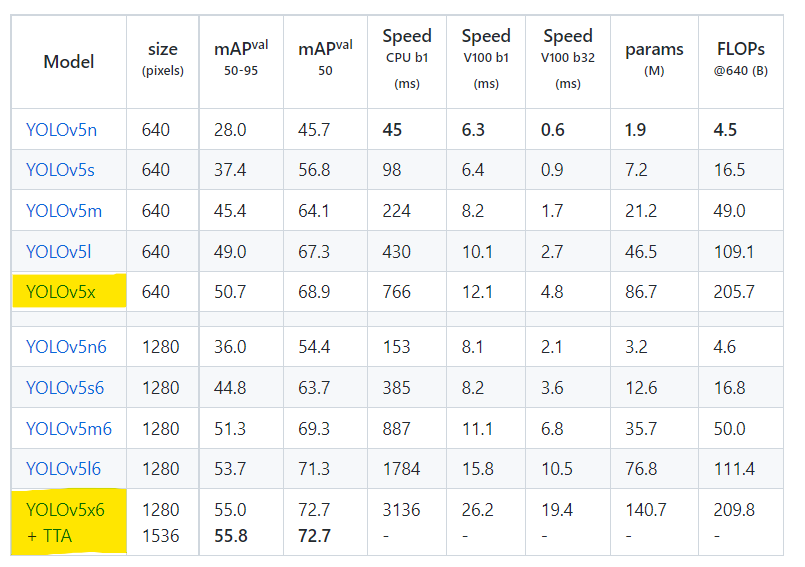



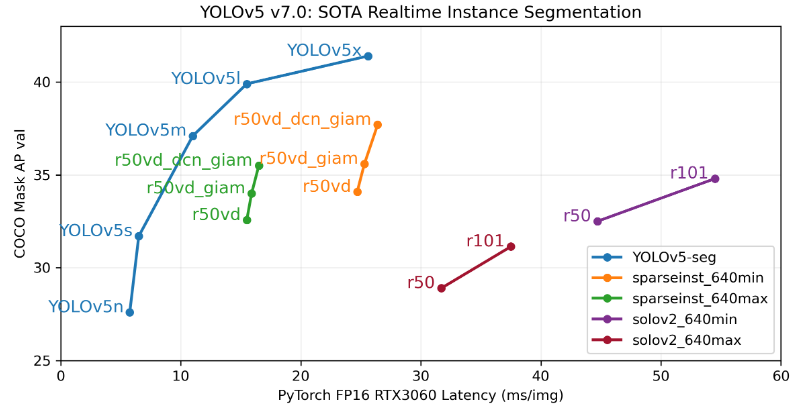

### <div style="direction:rtl"> شرح الگوریتم </div>
<div style="direction:rtl"> در این روش ما با تعیین فیلتر فقط "شخص" را  با وزن های مدل شناسایی می کنیم به این صورت که مختصات میز مورد نظر را به الگوریتم میدهیم با توجه به این مختصات فقط میز شخص بریده شده و به عنوان عکس ورودی به الگوریتم داده میشود. الگوریتم اگر شخصی با بیشتر از 45 درصد احتمال از کلاس person بود (tresh = 45) یعنی در مختصات مورد نظر شخص شناسایی شده است و میز پر است.
در غیر این صورت میز خالی است.
بر همین اساس با دیتاست خودمان که در آدرس زیر موجود است تست شد و نتایج در آخر فایل آورده شده است.
</div>
<div style="direction:rtl">آدرس دیتاست تهیه شده:  </div>
\\S.Ezati : working_time.zip
<div style="direction:rtl"> در مرحله بعد پیش پردازش هایی مانند تنظیم نور و contrast انجام شد که دقت الگوریتم را برای دیتاست خودمان به 99 درصد رسید. </div>
<div style="direction:rtl"> همچنین با بررسی دیتاست تهیه شده با الگوریتم فوق و حذف کردن عکس هایی که خوب نبودن به این نتیجه رسیدیم که موقعیت دوربین باید شرایط زیر را داشته باشد: 

1.	دوربین در فاصله کمتر از 6 متر از شخص باشد.
2.	دوربین حالت نیم رخ یا روبرو یا سه رخ شخص را ثبت کند.
3.	در دوربین صندلی و شخص مشخص باشد.

</div>
<div style="direction:rtl">همچنین ممکن است الگوریتم در حالت هایی که شخص بسیار دور باشد یا دوربین از پشت سر شخص تصویر را ثبت کند نتیجه خوبی نداشته باشد. </div>


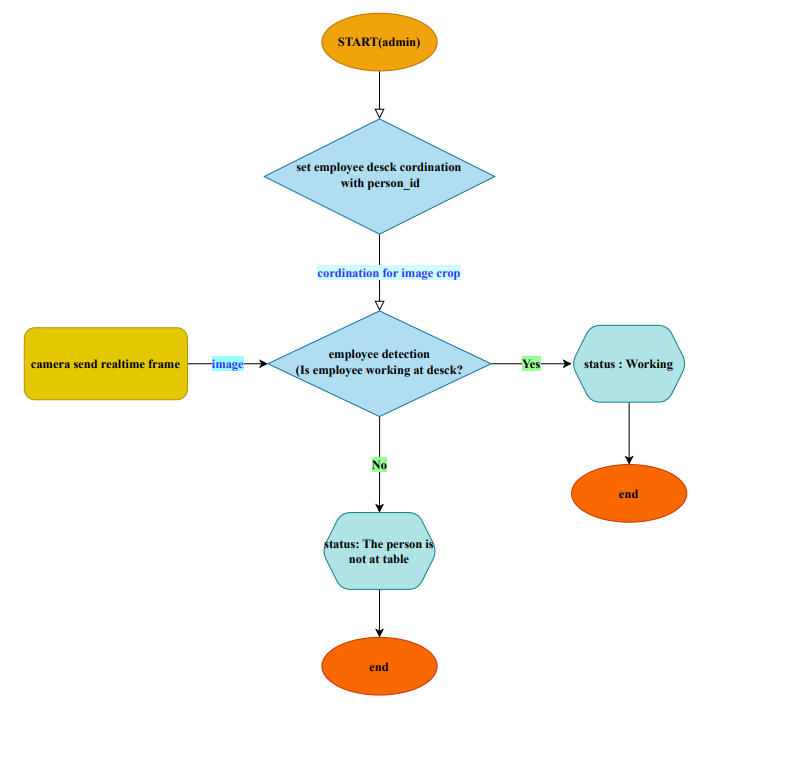



# <font color=BlueViolet> Person Detection Method </font>



In [5]:
import random
rgb_colors = []

def Person_Detection_Test(model, img, filter_ = 'person'):
    flag = False
    img = Image.fromarray(img)
    img = F.adjust_brightness(img, 1.5)
    img = F.adjust_contrast(img,1)
    img = F.adjust_sharpness(img,1)
#     img = F.adjust_gamma(img , 0.7)
#     img = F.adjust_hue(img, 0.07)
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    status = ''
    lable = 0

    with torch.no_grad(): results = model(img)

    if len(results.xyxy[0]) == 0: pass
    else:        
        for indx,res in enumerate(results.xyxy[0]):
            
            predict = results.pandas().xyxy[0]['name'][indx]
            if predict == filter_:
                res = np.array(res.detach().cpu())
#                 print(res[4]*100)
                if res[4]*100 > 45:
                    flag = True
                    status = 'working'
                    lable = 1
                    return status,lable
                    break
                else:
                    status = 'The person is not at table'
                    lable = 0

            else:pass

       
        if flag == False:
            status = 'The person is not at table'
            lable = 0
        
    return status,lable

# <font color=BlueViolet> Test For Me </font>


In [6]:
# file_path = 'C:/Users/s.ezati/Desktop/Meta/database create/working_time/images/*/*.jpg'
# frame = cv2.imread(file_path)
# status_model_1,y_pred_model_1 = Person_Detection_Test(model_1, frame,'person')

In [7]:
# from Denoiser.GFPGANer import GFPGANer_Model
# denoiser = GFPGANer_Model()

In [ ]:
file_path = 'C:/Users/s.ezati/Desktop/Meta/database create/working_time/images/full/frame2491.jpg'
img = Image.open(file_path)
frame = cv2.imread(file_path) 
# print(Person_Detection_Test(frame, img,'person'))


# img.show()
img = F.adjust_brightness(img, 1.5)
img = F.adjust_contrast(img,1)
img = F.adjust_sharpness(img,1)
# img = F.adjust_gamma(img , 0.4)
# img = F.adjust_hue(img, 0.07)

# _, _, restored_img = denoiser.enhance(np.array(img))
a , b = Person_Detection_Test(model_1, frame,'person')
print(Person_Detection_Test(model_2, frame,'person'))
results = model_2(img)
print(results.pandas().xyxy[0])
# plt.figure(figsize=(15,15))
plt.imshow(img)


('The person is not at table', 0)
         xmin       ymin        xmax       ymax  confidence  class    name
0   28.195387  38.176151  119.881714  91.235748    0.464628     56   chair
1   55.773067   0.237320   99.325195  72.146317    0.399211      0  person
2  102.497360  53.241730  119.850815  90.967010    0.285144     56   chair


# <font color=BlueViolet> Load Data and RUN Models </font>


In [60]:
file_path = 'C:/Users/s.ezati/Desktop/Meta/database create/working_time/images/*/*.jpg'

In [61]:
import glob

labels_model_1 = {
    'empty':[],
    'full':[],
}

images_model_1 = {
    'empty':[],
    'full':[],
}

labels_model_2 = {
    'empty':[],
    'full':[],
}

images_model_2 = {
    'empty':[],
    'full':[],
}

y_real_list = []
y_pred_list_model_1 = []
y_pred_list_model_2 = []
lable_real = 2
count = 0
for img in glob.glob(file_path):
    if count%100 == 0:
        print('*________________________*',f'{count}','*________________________*')
    count = count + 1
    y_real = img.split('\\')[1]
    if y_real=='empty':
        y_real_list.append(0)
        lable_real = 0
    elif y_real=='full':
        y_real_list.append(1)
        lable_real = 1
    else:
        break

    frame = cv2.imread(img) 
    
    status_model_1,y_pred_model_1 = Person_Detection_Test(model_1, frame,'person')
    y_pred_list_model_1.append(y_pred_model_1)
#     if lable_real != y_pred_model_1 :
#         print("model 1 : ", img, y_pred_model_1)
#         print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    
    
    status_model_2,y_pred_model_2 = Person_Detection_Test(model_2, frame,'person')
    y_pred_list_model_2.append(y_pred_model_2)
    if lable_real != y_pred_model_2 :
        print("model 2 : ", img, y_pred_model_2)
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

        



*________________________* 0 *________________________*
*________________________* 100 *________________________*
*________________________* 200 *________________________*
*________________________* 300 *________________________*
*________________________* 400 *________________________*
*________________________* 500 *________________________*
*________________________* 600 *________________________*
*________________________* 700 *________________________*
*________________________* 800 *________________________*
*________________________* 900 *________________________*
*________________________* 1000 *________________________*
*________________________* 1100 *________________________*
*________________________* 1200 *________________________*
*________________________* 1300 *________________________*
*________________________* 1400 *________________________*
*________________________* 1500 *________________________*
*________________________* 1600 *________________________*
*________

model 2 :  C:/Users/s.ezati/Desktop/Meta/database create/working_time/images\full\frame2748.jpg 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
model 2 :  C:/Users/s.ezati/Desktop/Meta/database create/working_time/images\full\frame2749.jpg 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
model 2 :  C:/Users/s.ezati/Desktop/Meta/database create/working_time/images\full\frame2750.jpg 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
*________________________* 2800 *________________________*
*________________________* 2900 *________________________*
*________________________* 3000 *________________________*
*________________________* 3100 *________________________*


In [63]:
#test for me
print(len(y_pred_list_model_1))
print(len(y_pred_list_model_2))

print(len(y_real_list))

3185
3185
3185


# <font color=BlueViolet> Accuracy Metrics </font>


In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score

print(classification_report(y_real_list, y_pred_list_model_1))
print('*________________________________________________*')

print(classification_report(y_real_list, y_pred_list_model_2))
print('*________________________________________________*')

confusion_matrix_model_1 = confusion_matrix(y_real_list, y_pred_list_model_1)
confusion_matrix_model_2 = confusion_matrix(y_real_list, y_pred_list_model_2)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1727
           1       0.98      0.74      0.84      1458

    accuracy                           0.88      3185
   macro avg       0.90      0.86      0.87      3185
weighted avg       0.89      0.88      0.87      3185

*________________________________________________*
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1727
           1       1.00      0.97      0.99      1458

    accuracy                           0.99      3185
   macro avg       0.99      0.99      0.99      3185
weighted avg       0.99      0.99      0.99      3185

*________________________________________________*


In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
from sklearn import metrics

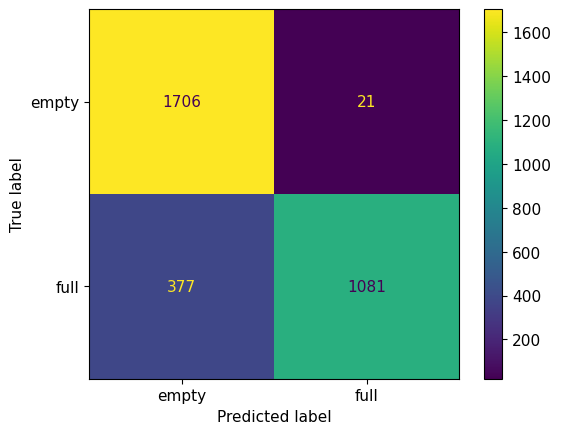

In [66]:
cm_display_model_1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_model_1,
                                            display_labels = ['empty', 'full'])

cm_display_model_1.plot()# cmap='bwr'
plt.show()


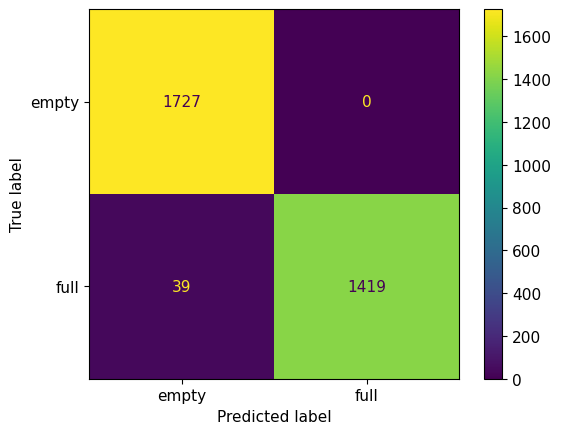

In [67]:
cm_display_model_2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_model_2,
                                            display_labels = ['empty', 'full'])

cm_display_model_2.plot()# cmap='bwr'
plt.show()



# <font color=DeepPink> accuracy report</font>



## <font color=DarkTurquoise > 1: without preprocessing _algorithm 1</font>

precision    recall  f1-score   support

           0       0.70      0.99      0.82      1727
           1       0.98      0.55      0.70      1631

    accuracy                               0.77      3358
    macro avg          0.84      0.77      0.76      3358
    weighted avg       0.83      0.77      0.76      3358



<!-- 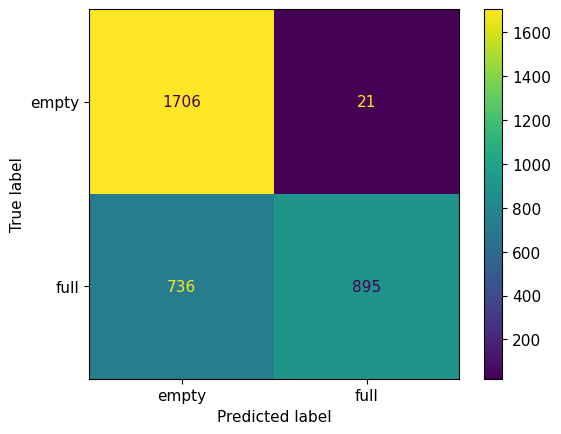  -->

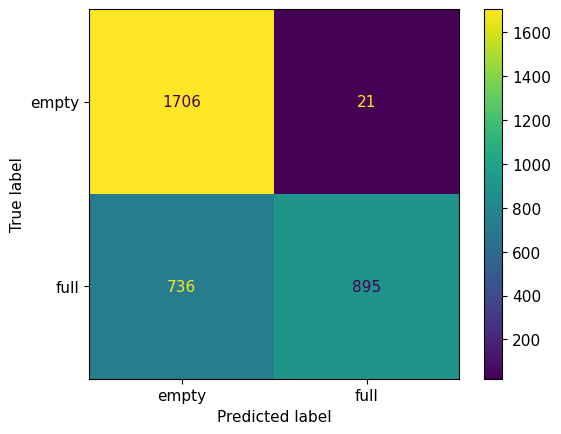



## <font color=DarkTurquoise > 2: without preprocessing _algorithm 2</font>

 precision    recall  f1-score   support

           0       0.94      0.99      0.97      1727
           1       0.99      0.93      0.96      1631

    accuracy                               0.97      3358
    macro avg          0.97      0.96      0.97      3358
    weighted avg       0.97      0.97      0.97      3358




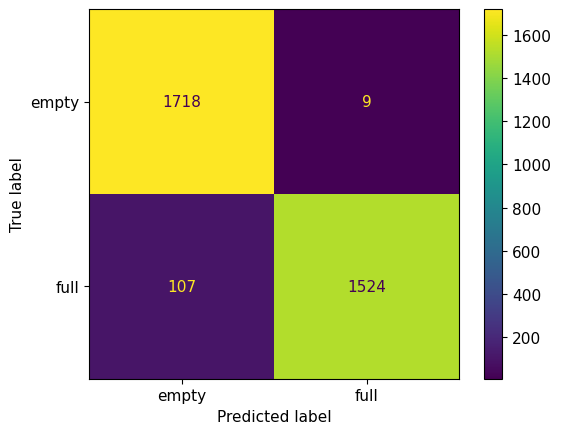

## <font color=DarkTurquoise > 3: with preprocessing _algorithm 1</font>


              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1727
           1       0.91      0.81      0.85      1460

    accuracy                               0.87      3187
    macro avg          0.88      0.87      0.87      3187
    weighted avg       0.88      0.87      0.87      3187

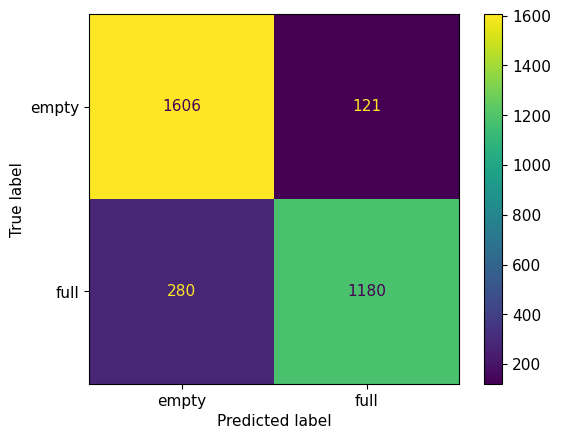



## <font color=DarkTurquoise > 4: with preprocessing _algorithm 2</font>


 precision    recall  f1-score   support

           0       0.95      1.00      0.97      1727
           1       1.00      0.94      0.97      1460

    accuracy                               0.97      3187
    macro avg          0.97      0.97      0.97      3187
    weighted avg       0.97      0.97      0.97      3187


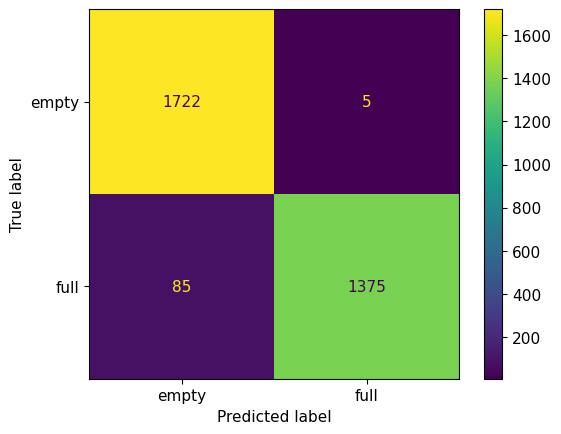

## <font color=DarkTurquoise > 5: with preprocessing _algorithm 1</font>
precision    recall  f1-score   support

           0       0.82      0.99      0.90      1727
           1       0.98      0.74      0.84      1458

    accuracy                               0.88      3185
    macro avg          0.90      0.86      0.87      3185
    weighted avg       0.89      0.88      0.87      3185


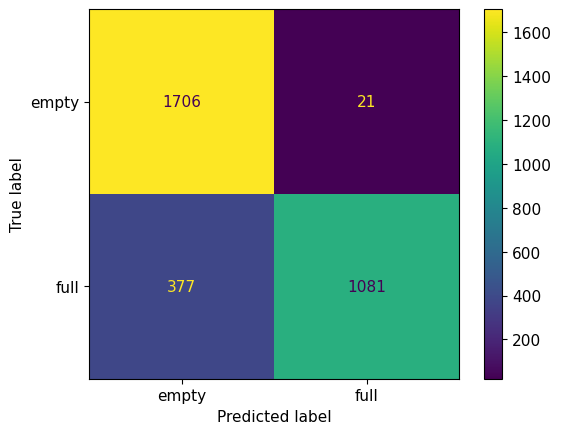



## <font color=DarkTurquoise > 6: with preprocessing _algorithm 2</font>

 precision    recall  f1-score   support

           0       0.98      1.00      0.99      1727
           1       1.00      0.97      0.99      1458

    accuracy                               0.99      3185
    macro avg          0.99      0.99      0.99      3185
    weighted avg       0.99      0.99      0.99      3185

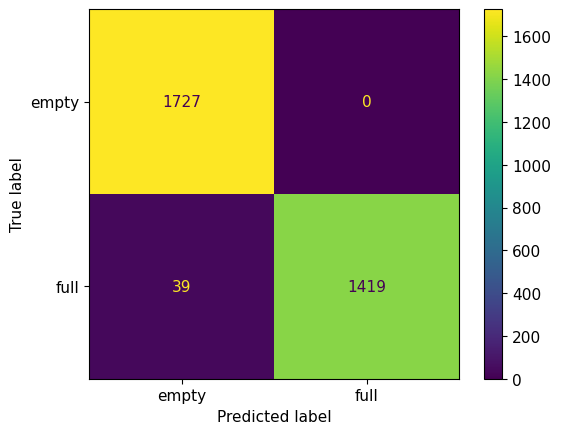